In [1]:
import pandas as pd

In [2]:
X = pd.read_parquet("./data/features_atc4.parquet")
y = pd.read_parquet("./data/labels.parquet")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from matplotlib import pyplot as plt

In [10]:
import torch

In [4]:
X["hour"] = X["intime"].dt.hour

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
categorical_features = [
    "gender",
    "hour"
]+X_train.columns[12:].tolist()

continuous_features = [
    "pain",
    "age",
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp"
]

In [7]:
features_preprocessing = ColumnTransformer([
    ("binary_encoder", OrdinalEncoder(), categorical_features),
    ("identity", StandardScaler(), continuous_features),
    ("missing", MissingIndicator(), continuous_features),
    ("nlp", Pipeline([
        ("cv", CountVectorizer(ngram_range=(1,2), max_features=500)),
        ("tf-idf", TfidfTransformer())
    ]), "chiefcomplaint"),
])

full_preprocessing = Pipeline([
    ("features", features_preprocessing),
    ("imputer", SimpleImputer())
])

pipeline = Pipeline([
    ("preprocessing", full_preprocessing),
    ("mlp", MLPClassifier(hidden_layer_sizes=(100,20), verbose=True, learning_rate_init=1e-3, batch_size=64, max_iter=100))
])

In [8]:
preprocesser = full_preprocessing.fit(X_train, y_train)

In [9]:
X_train_preprocess = torch.tensor(preprocesser.transform(X_train), dtype=torch.float32)
y_train_preprocess = torch.tensor(y_train.iloc[:,1:].values, dtype=torch.float32)
X_test_preprocess = torch.tensor(preprocesser.transform(X_test), dtype=torch.float32)
y_test_preprocess = torch.tensor(y_test.iloc[:,1:].values, dtype=torch.float32)

NameError: name 'torch' is not defined

In [ ]:
from torch import nn, optim
import torch

In [ ]:
class neural_net (nn.Module):
    def __init__(self, n_features, n_outputs):
        super().__init__()

        self.network = nn.Sequential(*[
            nn.Linear(n_features, 500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, n_outputs),
            nn.Sigmoid()
        ])

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4)

    def forward(self, x):
        
        y_hat = self.network(x)

        return y_hat
    
    def fit(self, x, y):

        self.train()
        self.optimizer.zero_grad()

        y_hat = self.forward(x)

        loss = self.loss(y_hat, y)

        loss.backward()
        self.optimizer.step()

        return loss

    def predict(self, x):
        
        self.eval()

        with torch.no_grad():            
            y_hat = self.predict(x)

        return y_hat

In [ ]:
network = neural_net(X_train_preprocess.shape[1], y_train_preprocess.shape[1])

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
data_loader = DataLoader(range(X_train_preprocess.shape[0]), shuffle=True, batch_size=4096)

In [16]:
n_epochs = 100
n_epoch_print = 1

for i in range(n_epochs):

    losses = []

    j = 0
    for indices in data_loader:
        X_tensor = torch.tensor(X_train_preprocess[indices,:], dtype=torch.float32)
        y_tensor = torch.tensor(y_train_preprocess[indices,:], dtype=torch.float32)

        loss = network.fit(X_tensor, y_tensor).detach().cpu().item()
        losses.append(loss)
        
        j += 1

    if (i%n_epoch_print) == 0:
        mean_loss = np.array(losses).mean()
        print(f"Epoch {i} - loss : {mean_loss}")

Epoch 0 - loss : 8.175965949742482
Epoch 1 - loss : 7.978885087099942


KeyboardInterrupt: 

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, recall_score, precision_score

In [18]:
y_hat = network.predict(X_test)
y_true = y_test.iloc[:,1:].values

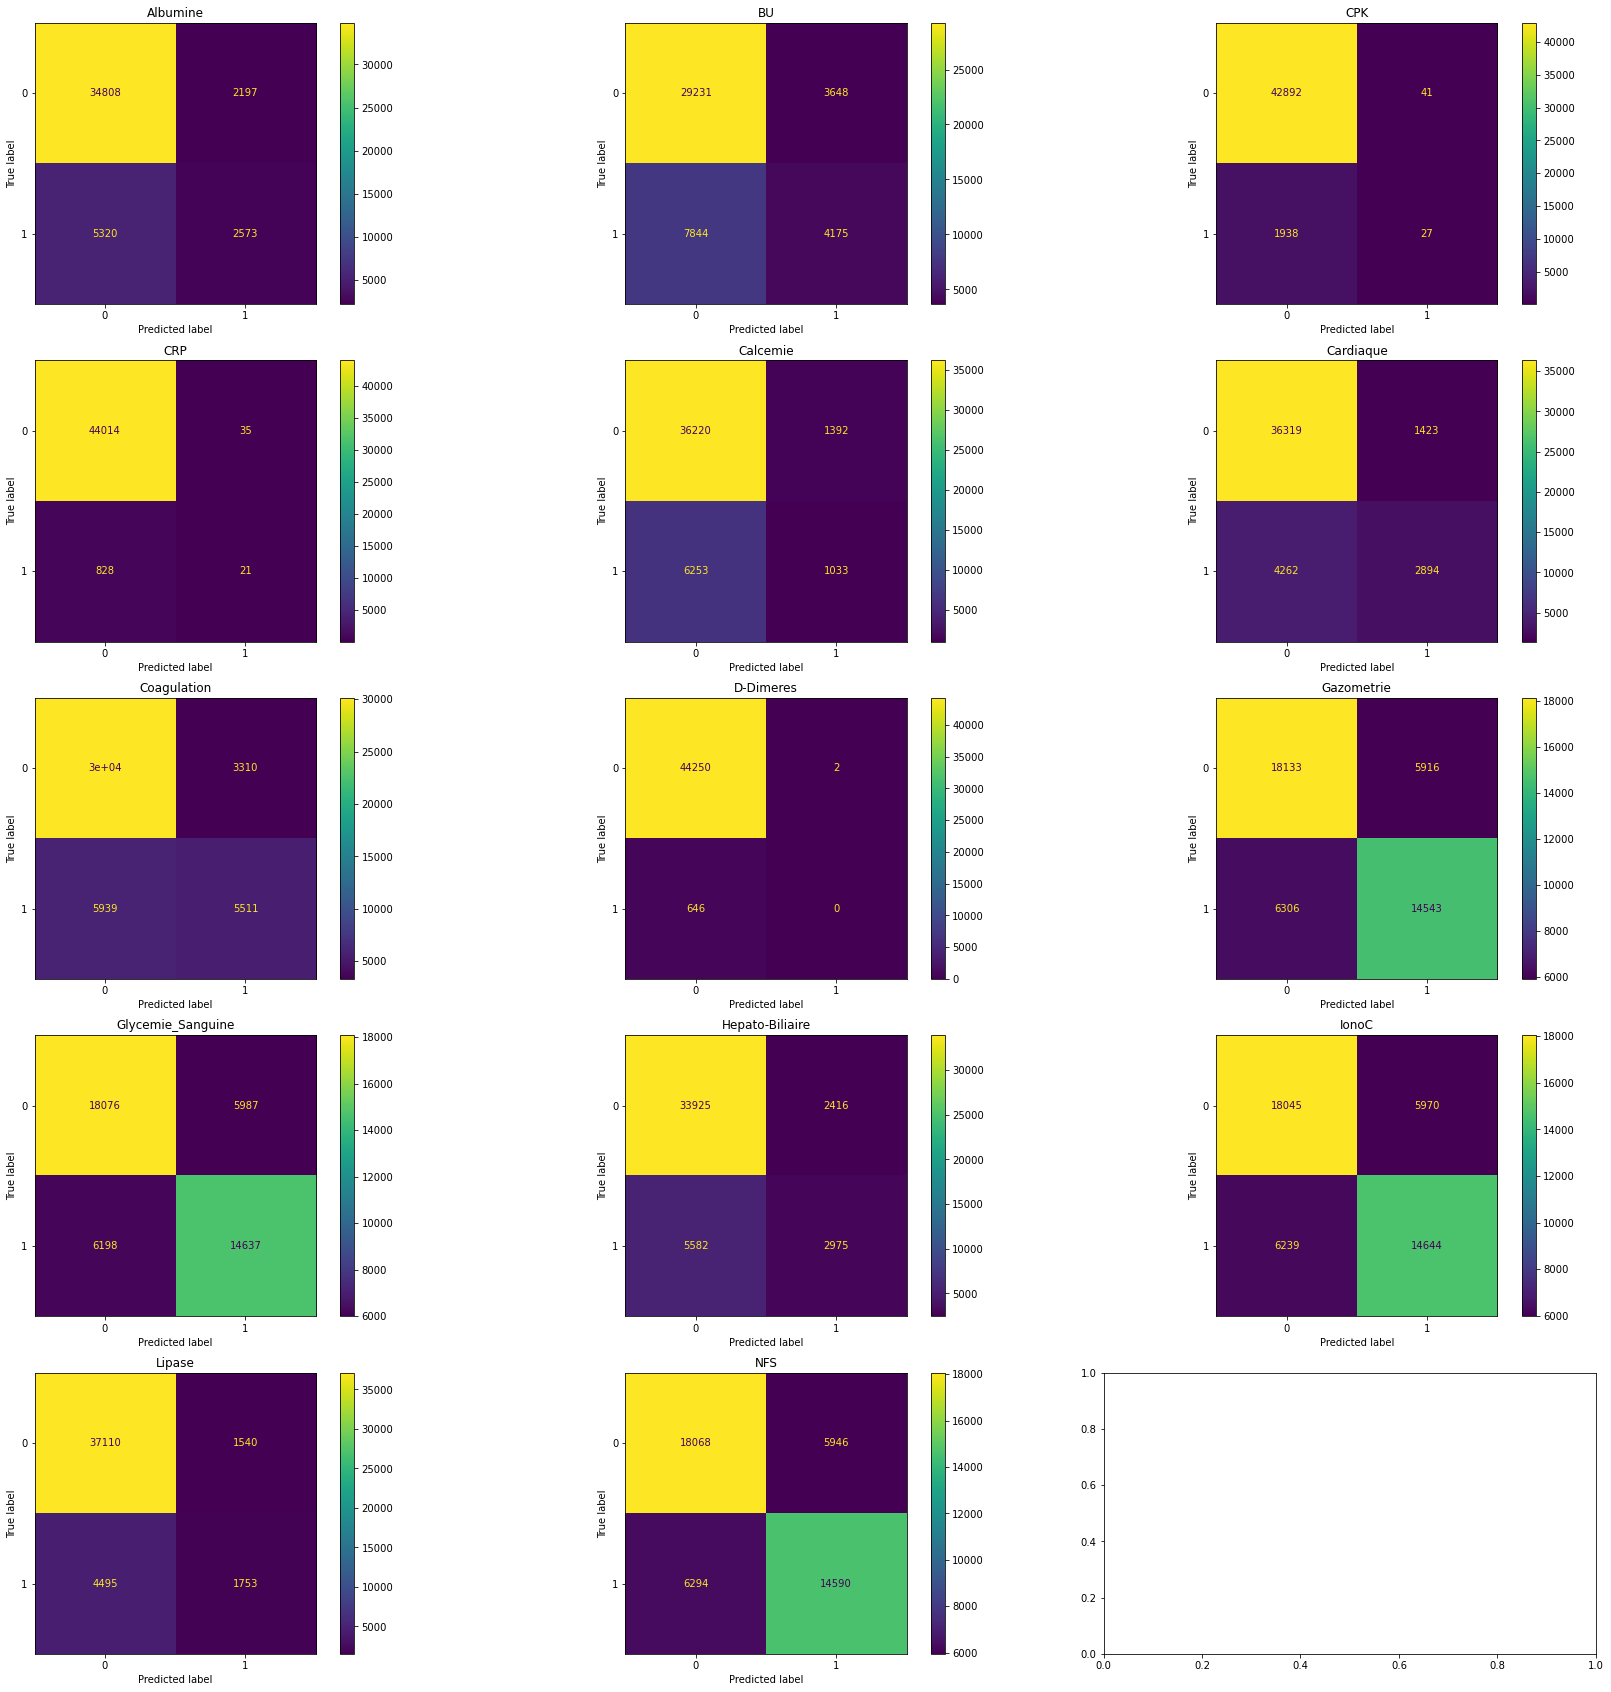

In [464]:
titles = y_train.columns.tolist()[1:]

n_cols = 3
n_rows = len(titles) // n_cols + int((len(titles)%n_cols) != 0)

figs, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30,30))
axs_flatten = axs.flatten()

for i in range(len(titles)):
    cm_plot = ConfusionMatrixDisplay(confusion_matrix(y_true[:,i], y_hat[:,i]))
    cm_plot.plot(ax=axs_flatten[i])
    axs_flatten[i].set_title(titles[i])

plt.show()

In [463]:
pd.DataFrame.from_dict(
    dict(zip(titles, np.concatenate([
        precision_score(y_true, y_hat, average=None, zero_division=0).reshape(1,-1),
        recall_score(y_true, y_hat, average=None, zero_division=0).reshape(1,-1),
        f1_score(y_true, y_hat, average=None).reshape(1,-1)
    ], axis=0).T)),
    orient="index",
    columns=["precision","recall","f1_score"]
).round(2)

,precision,recall,f1_score
Albumine,0.54,0.33,0.41
BU,0.53,0.35,0.42
CPK,0.40,0.01,0.03
CRP,0.38,0.02,0.05
Calcemie,0.43,0.14,0.21
Cardiaque,0.67,0.40,0.50
Coagulation,0.62,0.48,0.54
D-Dimeres,0.00,0.00,0.00
Gazometrie,0.71,0.70,0.70
Glycemie_Sanguine,0.71,0.70,0.71
